# COGS 108 - Final Project 

# Overview

This project evaluates the question of does the amount of times an inspector performs inspections in one day affect the score of the inspections given that day. Through exploratory data analysis with linear regression, I have come to the conclusion that there is significant evidence that supports the hypothesis that the number of times an inspector performs inspections in one day does in fact affect the score of the inspections given that day. After conducting a linear regression test, I calculated a p-value of 6.59e-06, indicating that the linear relationship is very unlikely due to chance. Therefore, I've concluded that there is a linear relationship between number of inspections per day and the scores of the inspection on those days, relative to the data given.

# Name & GitHub

- Name: Abish Wang
- GitHub Username: ayw034

# Research Question

*General Topic: How can we improve health inspections?* 

Does the amount of times an inspector performs inspections in one day affect the score of the inspection given that day?

## Background and Prior Work

Businesses have been improving their quality of cleanliness over the years in respect to health inspections, but further improvement can still be made. Because of the development of grade cards being displayed for customers to see, service providers have been more incentivized to clean their businesses to receive an A grade (score of 90+) from their health inspectors. However, the establishment of grade cards have caused health inspectors to be more pressured from busniness owners to receive higher grades. For example, if a business receives an 89, which is a B grade, they might pressure health inspectors to bump it up one point for an A. This causes a sort of inflation due to the pressure received by health inspectors and could decrease the standard of higher grades relative to health and safety in businesses. (Jin & Leslie, 2005)

On top of this pressure, the scheduling of health inspectors could also bias individual inspectors evaluations. Ibanez & Toffel (2005) "noticed that inspectors tended to cite fewer violations at each successive establishment they visited through their day — suggesting that the onerous work takes a toll on their meticulousness." This means that there could be bias formed by inspectors due to the time of day they inspect or how many inspections they must perform on a given day. Another issue they discovered was that the inspection of one facility would bias the inspections of other facilities visited that day. For example, if one establishment turned out to receive numerous violations, the next few establishments visited would be scrutinized more vehemently than on a day where the first establishment visited had very few violations. Ibanez & Toffel (2005) suggested that one solution could be to reduce the amount of "crunch days" that inspectors have, as in limiting the number of inspections an individual inspector has to go through in a single day so that their fatigue does not bias their inspections on certain businesses. 


References (include links):
- 1) Ibanez, M. R., & Toffel, M. W. (2019, May 16). To Improve Food Inspections, Change the Way They’re Scheduled. Retrieved April 23, 2020, from https://hbr.org/2019/05/to-improve-food-inspections-change-the-way-theyre-scheduled
- 2) Jin, G. Z., & Leslie, P. (2005). The Case in Support of Restaurant Hygiene Grade Cards. Choices, 97–102.

# Hypothesis


My hypothesis is that the number of times an inspector performs inspections in one day will affect the score(s) that they give. I believe this because inspectors may have human error, and when having to perform more inspections on a day, may tire or have biases based on previous inspections.

# Dataset(s)


- Dataset Name: inspections.csv
- DataFrame Name: inspections
- Link to the dataset: inspections.csv (data given by instructor)
- Number of observations: 18466

- Description: This data set has rows which indicate an inspection and an abundance of information about the inspections, restaurants, and inspectors. I mainly used it for inspector ID, date, and scores.

# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns


import matplotlib as mpl
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skewnorm

# Data Cleaning

In [2]:
## Main dataset used as a DataFrame
inspections = pd.read_csv('inspections.csv')

## Drop columns that are not useful to see all columns
inspections = inspections.drop(columns=['address1', 'address2', 'phonenumber', 'restaurantopendate', 'top_match', 
                                        'second_match', 'x', 'y', 'city', 'postalcode', 'state', 'geocodestatus', 
                                        'zip', 'days_from_open_date', 'facilitytype', 'name', 'type', 
                                        'num_critical_previous', 'num_non_critical_previous', 
                                        'avg_neighbor_num_critical', 'avg_neighbor_num_non_critical', 
                                        'num_critical_mean_previous', 'num_non_critical_mean_previous', 'inspectedby', 'description'])

In [3]:
## Delete useless/repetitive data within date
def fix_date(date):
    if date.endswith('T00:00:00Z'):
        date = date[:-10]
    return date

In [4]:
inspections['date'] = inspections['date'].apply(fix_date)
inspections.head()

,hsisid,date,inspection_num,inspector_id,previous_inspection_date,days_since_previous_inspection,previous_inspection_by_same_inspector,score,num_critical,num_non_critical,critical
0,4092013748,2012-09-21,1,27.0,NaN,NaN,NaN,96.0,9,7,1
1,4092014046,2012-09-21,1,7.0,NaN,NaN,NaN,98.0,0,11,0
2,4092015191,2012-09-21,1,3.0,NaN,NaN,NaN,97.0,4,8,1
3,4092016122,2012-09-21,1,24.0,NaN,NaN,NaN,99.0,2,3,1
4,4092021513,2012-09-21,1,7.0,NaN,NaN,NaN,97.0,2,4,1


In [5]:
## Function that returns number of inspections per day, given the date and inspector ID
def inspections_per_day(day, i_id):
    
    df = inspections.loc[inspections['date'] == day].reset_index()
    dic = {}
    
    for i in range(33):
        dic[i] = 0
        
    for i in range(len(df)):
        for j in range(33):
            if df['inspector_id'][i] == j:
                dic[j] += 1
    
    return dic[i_id]

In [6]:
## Function that returns a dictionary with the key of the inspector's ID, and values of how many times the given 
## inspector had inspections on every date in the inspections dataframe.
def inspector_per_date(id):
    all_dates = inspections['date'].unique()
    dic = {}
    ls = []
    

    for i in all_dates:
        ls.append(inspections_per_day(i, id))
        dic[id] = ls
    return dic

dic = inspector_per_date(1)

for i in range(2, 33):
    add_dic = inspector_per_date(i)
    dic.update(add_dic)

## Created dataframe with dates as the rows and inspector ID's as columns. Indicates how many times each inspector
## had (an) inspection(s) on each date.
dates = inspections['date'].unique()
inspect_times_per_id = pd.DataFrame(data=dic, index=dates)

inspect_times_per_id.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
2012-09-21,0,0,1,0,0,0,2,0,0,0,...,0,1,0,0,1,1,0,0,0,0
2012-09-24,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-09-25,1,0,1,2,0,1,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0
2012-09-26,2,0,0,2,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,1
2012-09-27,2,0,1,2,1,0,0,0,0,2,...,0,0,2,0,0,2,0,0,0,0


In [7]:
## Created a dataframe that shows the number of inspections an inspector had in a day as the columns, and 
## inspector ID as the rows.

inspect_times_per_id = inspect_times_per_id.rename(columns={"index": "date"})

## Eight was the maximum of how many inspections a single inspector had in one day
max_inspections_in_one_day = 8
ls1 = []
ls2 = []
ls3 = []
ls4 = []
ls5 = []
ls6 = []
ls7 = []
ls8 = []
for i in range(1, 33):
    if i == 30:
        ls1.append(0)
        continue
    ls1.append(inspect_times_per_id[i].value_counts()[1])
    
for i in range(1, 33):
    if i in [17, 30]:
        ls2.append(0)
        continue
    ls2.append(inspect_times_per_id[i].value_counts()[2])

for i in range(1, 33):
    if i in [12, 17, 26, 30]:
        ls3.append(0)
        continue
    ls3.append(inspect_times_per_id[i].value_counts()[3])

for i in range(1, 33):
    if i in [8, 12, 16, 17, 24, 26, 30, 31, 32]:
        ls4.append(0)
        continue
    ls4.append(inspect_times_per_id[i].value_counts()[4])
for i in range(1, 33):
    if i in [3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 27, 29, 30, 31, 32]:
        ls5.append(0)
        continue
    ls5.append(inspect_times_per_id[i].value_counts()[5])
for i in range(1, 33):
    if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32]:
        ls6.append(0)
        continue
    ls6.append(inspect_times_per_id[i].value_counts()[6])
for i in range(1, 33):
    if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32]:
        ls7.append(0)
        continue
    ls7.append(inspect_times_per_id[i].value_counts()[7])
for i in range(1, 33):
    if i in [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]:
        ls8.append(0)
        continue
    ls8.append(inspect_times_per_id[i].value_counts()[8])

inspects_dic = {}
inspects_dic[1] = ls1
inspects_dic[2] = ls2
inspects_dic[3] = ls3
inspects_dic[4] = ls4
inspects_dic[5] = ls5
inspects_dic[6] = ls6
inspects_dic[7] = ls7
inspects_dic[8] = ls8
inspects_df = pd.DataFrame(data=inspects_dic)
inspects_df = inspects_df.rename(index={0:1, 1:2, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:13, 13:14, 14:15, 15:16, 
                          16:17, 17:18, 18:19, 19:20, 20:21, 21:22, 22:23, 23:24, 24:25, 25:26, 26:27, 27:28, 28:29, 
                          29:30, 30:31, 31:32})
inspects_df.head()

,1,2,3,4,5,6,7,8
1,301,291,111,32,5,0,0,0
2,335,215,68,22,3,0,0,0
2,363,202,58,4,0,0,0,0
4,75,23,3,1,1,0,0,0
5,281,188,73,7,0,0,0,0


In [8]:
## Function that returns the total average score of all inspections with the given number of inspections in a day.
## Ex. Gives you the average score of all times any inspector had 3 inspections
def avg_score_per_inspections(num_inspections):
    
    ls = []

    for i in dates:
        for j in range(1,33):
            if inspections_per_day(i, j) == num_inspections:
                ls.append((inspections['score'].loc[inspections['date'] == i].loc[inspections['inspector_id'] == j]).mean())
    
    return sum(ls)/len(ls)

In [13]:
## Create a dictionary from average scores of number of inspections to create a DataFrame for analysis
avg_scores_per_dic = {}
for i in range(1, 9):
    avg_scores_per_dic[i] = avg_score_per_inspections(i)
avg_scores_per_dic

{1: 95.97799422799423,
 2: 96.13710486703462,
 3: 96.57548940734783,
 4: 96.90800865800865,
 5: 97.14000000000001,
 6: 97.15833333333333,
 7: 97.58333333333331,
 8: 98.075}

# Data Analysis & Results

In [21]:
## Create dataframe of average scores of (n = 1-8) inspections
avg_scores_per_dic[1] = [avg_scores_per_dic[1]]
avg_scores_per_dic[2] = [avg_scores_per_dic[2]]
avg_scores_per_dic[3] = [avg_scores_per_dic[3]]
avg_scores_per_dic[4] = [avg_scores_per_dic[4]]
avg_scores_per_dic[5] = [avg_scores_per_dic[5]]
avg_scores_per_dic[6] = [avg_scores_per_dic[6]]
avg_scores_per_dic[7] = [avg_scores_per_dic[7]]
avg_scores_per_dic[8] = [avg_scores_per_dic[8]]

avg_scores_per_df = pd.DataFrame(data = avg_scores_per_dic)
avg_scores_per_df = avg_scores_per_df.T
avg_scores_per_df = avg_scores_per_df.rename(columns={0: 'Average_Score'})
avg_scores_per_df['Inspections_per_Day'] = avg_scores_per_df.index
avg_scores_per_df

,Average_Score,Inspections_per_Day
1,95.977994,1
2,96.137105,2
3,96.575489,3
4,96.908009,4
5,97.140000,5
6,97.158333,6
7,97.583333,7
8,98.075000,8


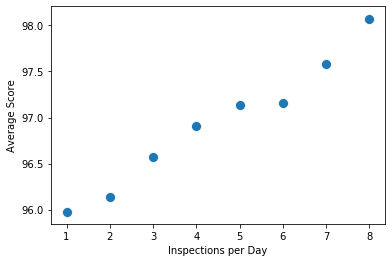

In [22]:
## Create scatterplot of inspections per day as the x axis and the average score as the y axis
sns.scatterplot(x='Inspections_per_Day', y='Average_Score', data=avg_scores_per_df, s=100)
plt.xlabel('Inspections per Day')
plt.ylabel('Average Score');

In the cell above, we can see a scatterplot of the average scores of inspections per day. This indicates that there is a fairly strong linear relationship between the average scores of inspections per day and inspections per day.

Text(0.5, 0, 'Score')

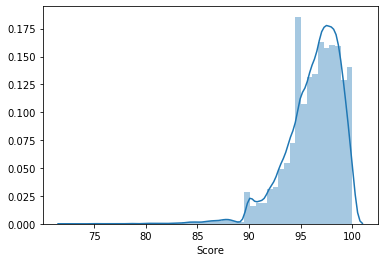

In [23]:
## Histogram - Distribution of Scores in inspections.csv
sns.distplot(inspections['score'])
plt.xlabel('Score')

In the cell above, we can visualize the distribution of scores, which is roughly normal, with a peak around 95, and skewed to the left.

In [24]:
## Set up for regression results
outcome, predictors = patsy.dmatrices('Average_Score ~ Inspections_per_Day', avg_scores_per_df)

In [25]:
mod = sm.OLS(outcome, predictors)

In [26]:
## Results of hypothesis test
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Average_Score   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     211.9
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           6.59e-06
Time:                        22:26:45   Log-Likelihood:                 6.3320
No. Observations:                   8   AIC:                            -8.664
Df Residuals:                       6   BIC:                            -8.505
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              95.6645    

I used linear regression testing to come up with these results to see if there was a correlation between the variables of number of inspections per day and scores received.

From these results, we can see that at 0 inspections per day (according to our data), the average score would be 95.6645 which increases by 0.2844 with every +1 increment of inspections per day.

There is a strong, positive linear relationship between the two variables observed, as indicated by the correlation coefficient (r = 0.9861).

We see that the p-value is 6.59e-06, which is much less than the alpha level of 0.01. Therefore, we can support the alternative hypothesis, and reject the null hypothesis, that the number of inspections per day does not affect the score given during an inspection.

We can conclude that we have sufficient evidence that the number of times these inspector had (an) inspection(s) per day has a linear relationship with the scores facilities receive in the locations where data was given.

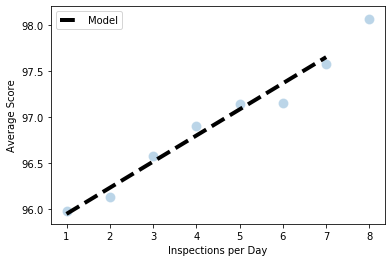

In [27]:
## Scatter plot with best of fit line
sns.scatterplot(x='Inspections_per_Day', y='Average_Score', alpha=0.3, data=avg_scores_per_df, s=100)

# Generate and plot the model fit line
xs = np.arange(avg_scores_per_df['Inspections_per_Day'].min(), avg_scores_per_df['Inspections_per_Day'].max())
ys = 0.2844 * xs + 95.6645
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Inspections per Day')
plt.ylabel('Average Score')
plt.legend();

In the cell above, we can see the same scatterplot as before, with a line of best fit drawn over the data values. This line of best fit was created from the regression results indicating a y-intercept of 95.6645 and slope of 0.2844.

# Ethics & Privacy

In regards to ethics and privacy, there should be no concerns regarding the datasets as restaurants are required to provide their customers with the knowledge of the results of these health inspections. This kind of data is not restricted and can be accessed by anyone. With the intent to be ethical concerning privacy, the names of inspectors, have been removed from the dataset and replaced with a unique identifier. Addresses, phone numbers, and other personally identifiable information has been removed from the data set. This data is not harmful to anyone and the analysis does not apply to all locations or inspectors as we only used a given number of inspections; it only applies to the inspections where data was available.

# Conclusion & Discussion

With regards to improving health inspections, I wanted to research the question of does the amount of inspections an inspector has in one day affect the scores they give. The impact on society that this has is that it could demonstrate how changing the schedule of inspectors, or giving them an optimum amount of inspections per day could potentially improve the consistency of inspections and limit biases that occur with a less preferred amount of inspections per day.

In researching this question, I found that researchers studied how inspectors become wary throughout the day and feel pressured by restaurant/facility owners to give them a certain score, which could influence the scores inspectors give. Ibanez & Toffel (2005) proposed that limiting the amount of "crunch days" could limit the biases of the inspectors so that their judgement on scores is not prejudiced.

In trying to determine whether or not the number of inspections per day has an effect on scores given, I wanted to see if there was a linear relationship between the two variables.
After cleaning data and creating functions that aid in obtaining results, I created a dataframe that indicates the average scores of all inspectors that had an x amount of inspections that day. Through that dataframe I created scatterplots and performed a linear regression test of the values of that dataframe to access the results indicating whether there was a linear relationship or not. I determined that there was a linear relationship between the two variables as the p-value was much less than an alpha level of 0.01. This indicated that it was highly unlikely the linear relationship was due to chance, supporting my hypothesis that the amount of inspections an inspector has in one day does affect the scores that they give.

The most adverse limitation was time. For some of my methods, it took over 30 minutes to run, as it had to iterate through the 'inspections' dataset multiple times. I wanted to create a dataframe and scatterplot with all the values of the inspections, instead of just the averages, so that I could have tested it with linear regression, which may have alter my results; but with the each run taking so long, time was certainly a restriction.

In conclusion, I obtained the results that there is a strong, positive linear relationship between the average of scores of n (1-8) inspections per day and inspections per day. This demonstrates that there is an affect of scores depending on the number of inspections an inspector had in one day with the data that was given.